In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted
import pickle
from dash.dependencies import Input, Output

from dash import dcc, html
import dash
import plotly.express as px


In [2]:
data = pd.read_csv(r"C:\Users\HP\Downloads\diabetesdataset.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
print("data type:", type (data))
print("data shape:", data.shape)
print(data.head())

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


<Axes: >

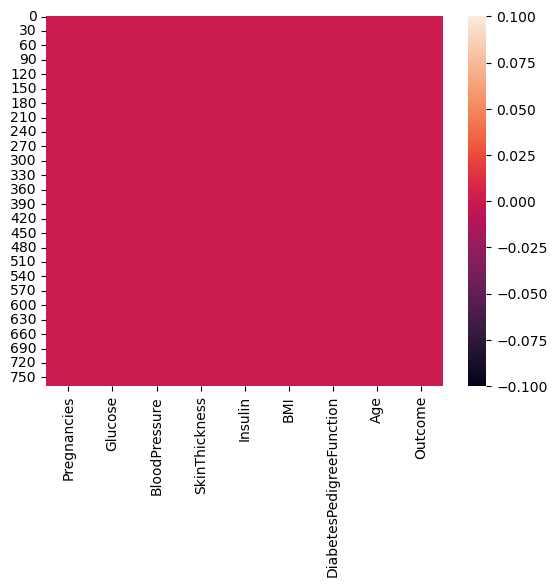

In [5]:
sns.heatmap(data.isnull())

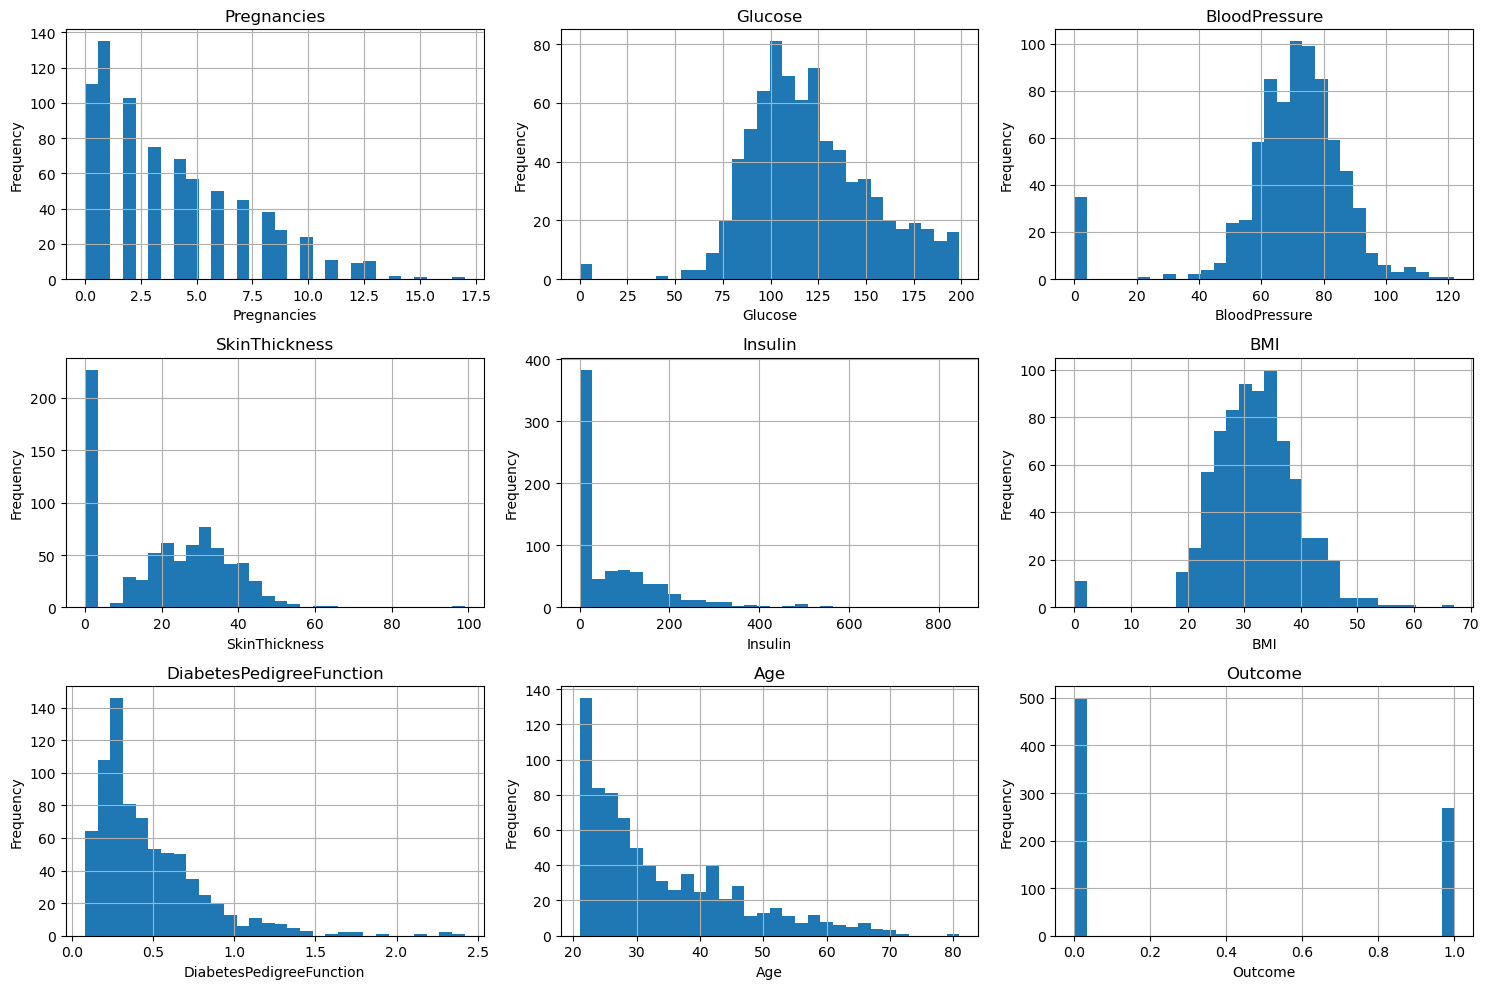

In [6]:
# Plot histograms
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    data[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()



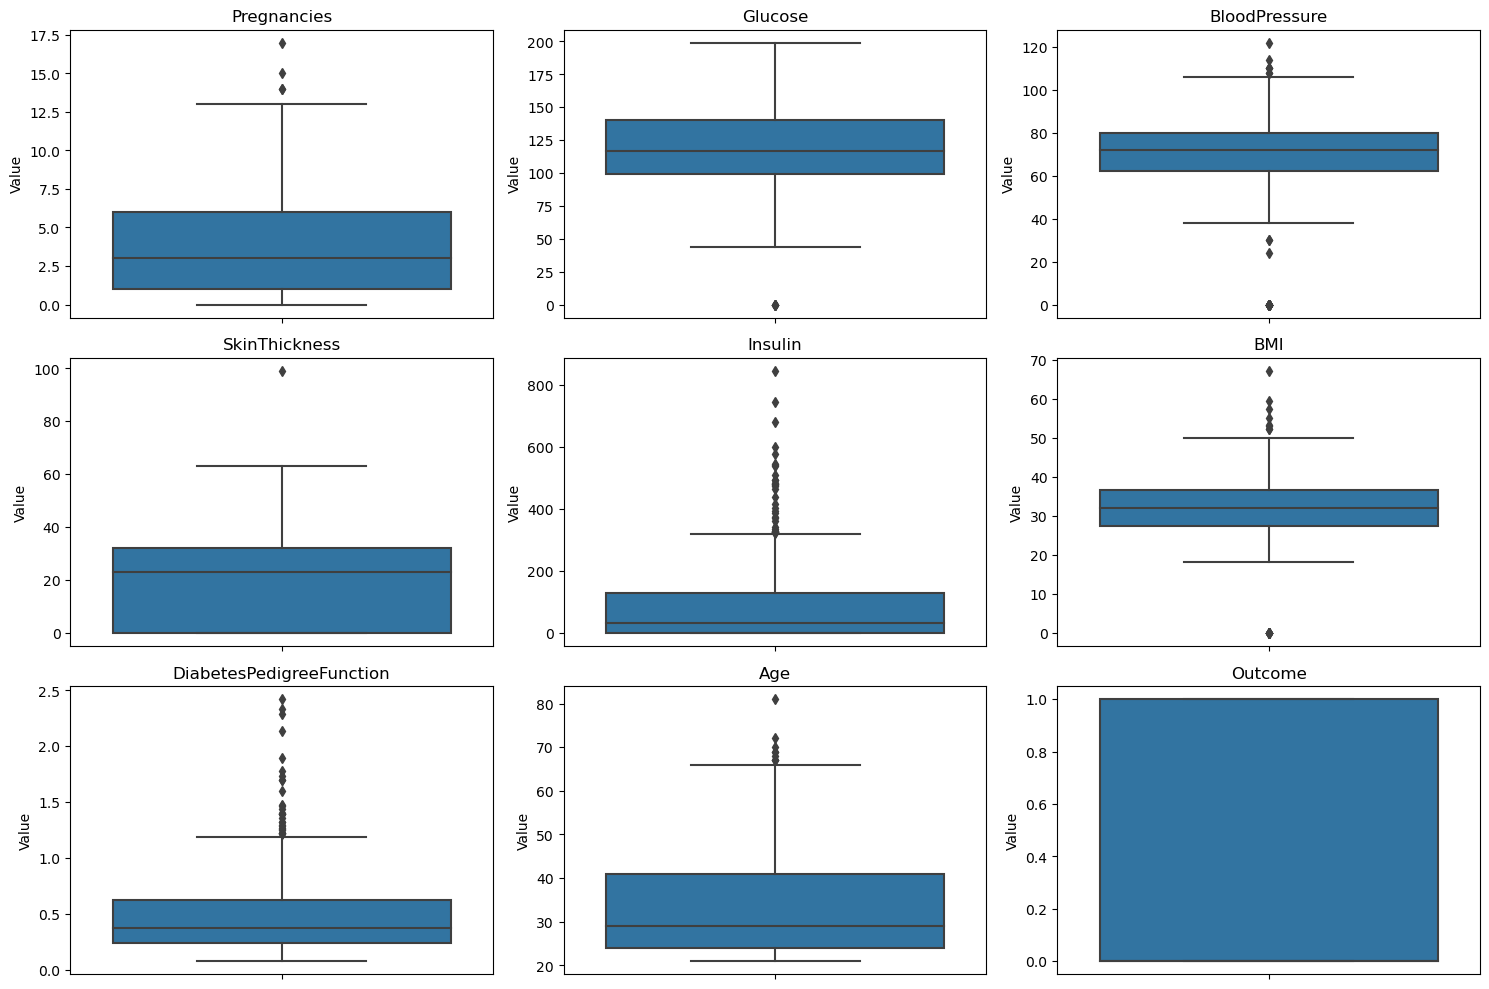

In [7]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[column])
    plt.title(column)
    plt.ylabel("Value")  

plt.tight_layout()
plt.show()


In [8]:
def remove_outliers(df):
    # Identify numeric columns
    numeric_columns = df.select_dtypes(include=[float, int]).columns

    for col in numeric_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bound for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df


In [9]:
# Remove outliers from the dataset
cleaned_data = remove_outliers(data)

# Check the shape of the data before and after removing outliers
print("Original data shape:", data.shape)
print("Cleaned data shape:", cleaned_data.shape)



print(cleaned_data.head())

Original data shape: (768, 9)
Cleaned data shape: (636, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
5            5      116             74              0        0  25.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
5                     0.201   30        0  


In [10]:
# Check some statistics to verify outliers removal
print("Original data statistics:\n", data.describe())
print("Cleaned data statistics:\n", cleaned_data.describe())

Original data statistics:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min     

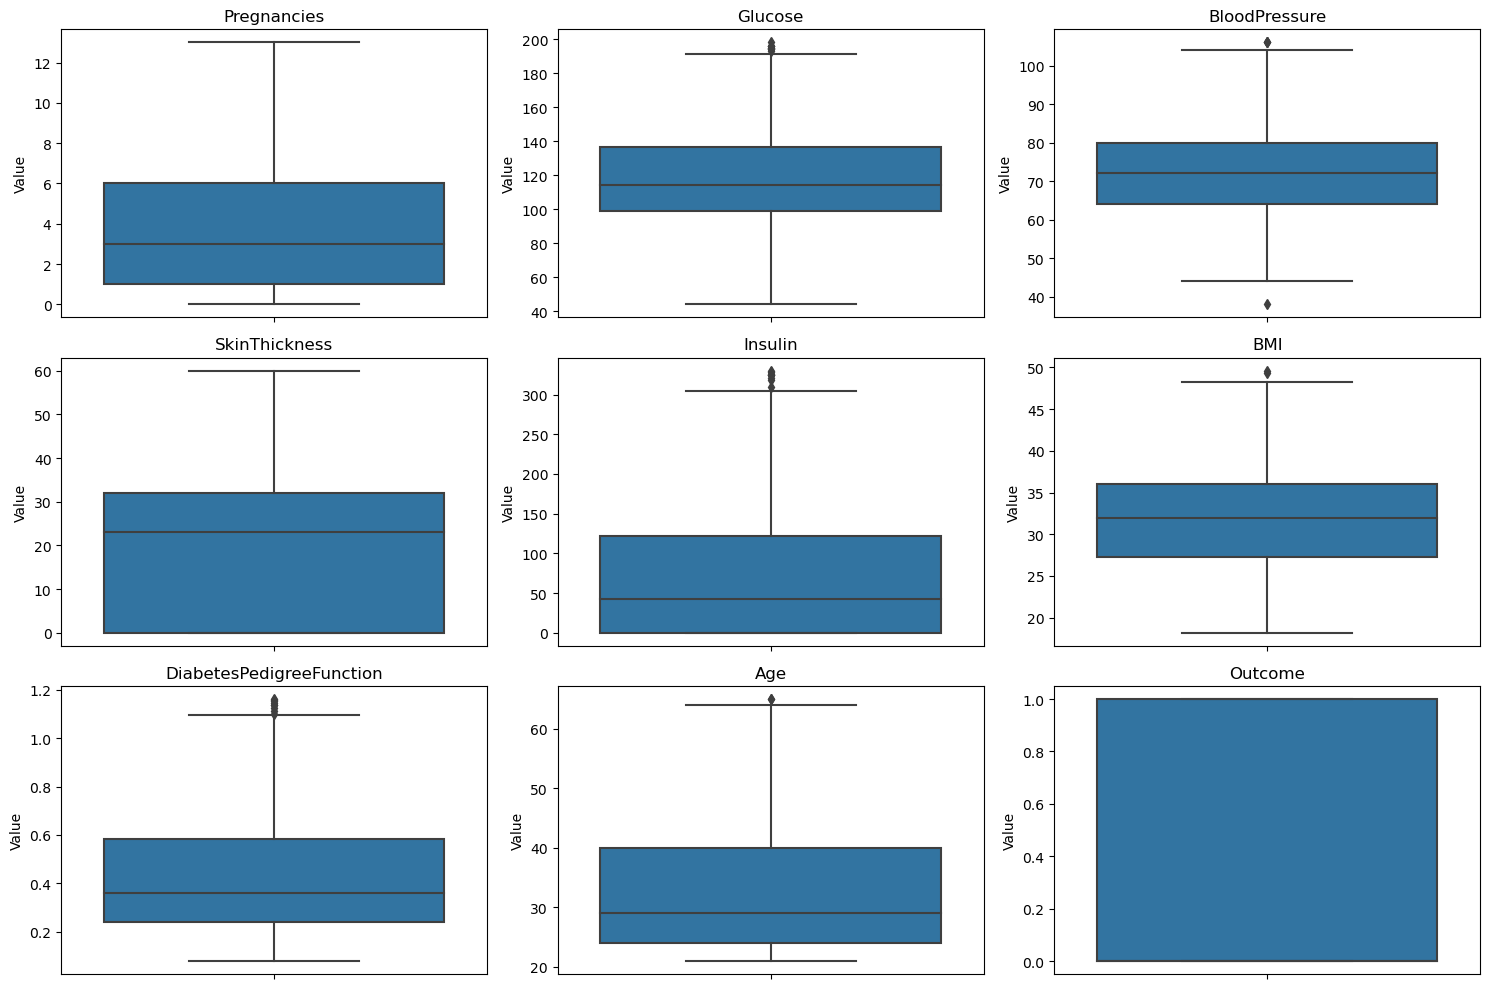

In [25]:
# Plot the cleaned data
plt.figure(figsize=(15, 10))

for i, column in enumerate(cleaned_data.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=cleaned_data[column])
    plt.title(column)
    plt.ylabel("Value")

plt.tight_layout()
plt.show()



In [26]:
target = "Outcome"
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

y_train = data[target]  
X_train = data[features]


In [27]:
target = "Outcome"
y_train = data[target] 
print(y_train.head())

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64


In [28]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X_train = data[features]
print(X_train.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33  


In [29]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)


print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (614, 8)
Shape of X_test: (154, 8)
Shape of y_train: (614,)
Shape of y_test: (154,)


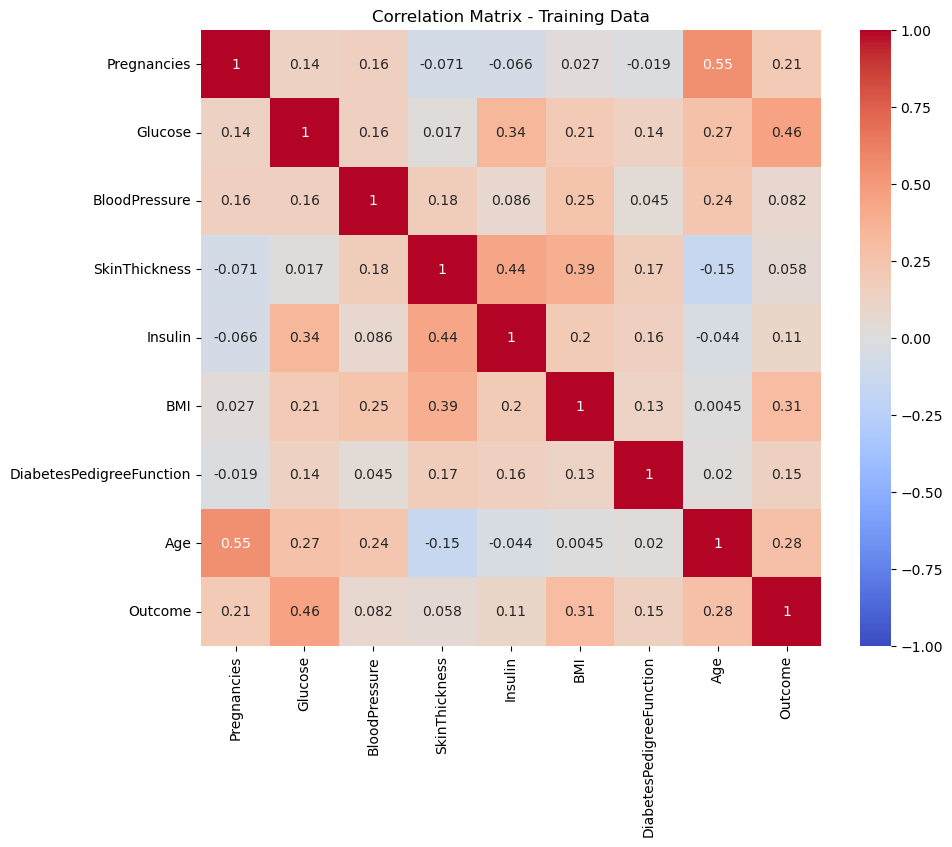

In [30]:
train_data = pd.concat([X_train, y_train], axis=1)
correlation_matrix = train_data.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Training Data')
plt.show()

In [31]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("MAE:", y_mean)
print("Baseline MAE :", mean_absolute_error(y_train, y_pred_baseline))

MAE: 0.3469055374592834
Baseline MAE : 0.4531241710787382


In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [43]:
X_test_scaled = scaler.transform(X_test)  # Assuming 'scaler' is already fitted on X_train
y_pred = logistic_regression_model.predict(X_test_scaled)

print("Predicted Labels:")
print(y_pred)


Predicted Labels:
[0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0]


In [44]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7532467532467533


In [36]:
feature_importance = logistic_regression_model.coef_[0]
print(feature_importance)

[ 0.21255833  1.07113231 -0.24784154  0.04569683 -0.2008266   0.77815151
  0.23060673  0.42100175]


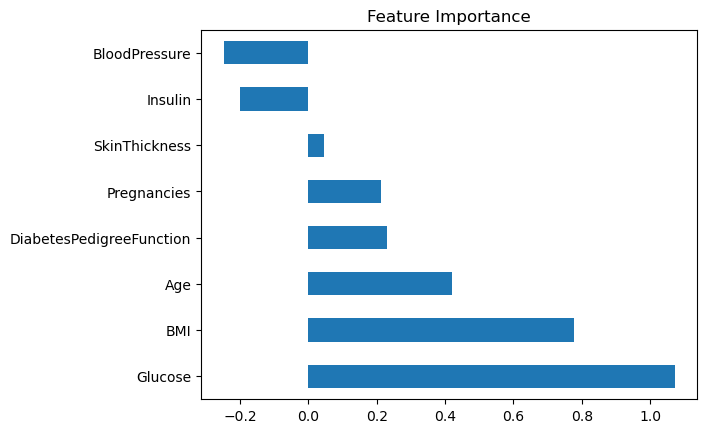

In [50]:
importance = logistic_regression_model.coef_[0]
feature_importance = pd.Series(importance, index=features)
feature_importance.nlargest(8).plot(kind='barh')
plt.title('Feature Importance')
plt.show()


In [46]:
app = dash.Dash(__name__)

In [47]:
from dash.dependencies import Input, Output


# Initialize Dash app

app.layout = html.Div([
    html.H1("Exploratory Data Analysis"),
    
    # Dropdown for selecting columns
    dcc.Dropdown(
        id='dropdown-column',
        options=[{'label': col, 'value': col} for col in data.columns],
        value='Pregnancies',  # Default column to display
        style={'width': '50%'}
    ),
    
    # Scatter plot based on selected column
    dcc.Graph(id='scatter-plot'),
])

# Callback to update scatter plot based on dropdown selection
@app.callback(
    dash.dependencies.Output('scatter-plot', 'figure'),
    [dash.dependencies.Input('dropdown-column', 'value')]
)
def update_scatter_plot(selected_column):
    fig = px.scatter(data, x=selected_column, y='Pregnancies', color='Outcome',
                     marginal_y='violin', marginal_x='box', trendline='ols')
    fig.update_layout(title=f'Scatter plot of {selected_column} vs BMI')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(port=8051, debug=True)
